# Projeto Marinha do Brasil

## Laboratório de Processamento de Sinais - UFRJ

### Autor: Vinícius dos Santos Mello <viniciusdsmello@poli.ufrj.br>

#### Notebook destinado a análise de Classificação dos Stacked Autoencoder (SAE)

In [1]:
import sys
import os
import time
import multiprocessing
import pprint 

from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt

from Packages.NoveltyDetection.setup.noveltyDetectionConfig import CONFIG
from Packages.NoveltyDetection.StackedAutoEncoders.SAENoveltyDetectionAnalysis import SAENoveltyDetectionAnalysis
from Functions.telegrambot import Bot

num_processes = multiprocessing.cpu_count()

my_bot = Bot("lisa_thebot")

# Enviroment variables
data_path = CONFIG['OUTPUTDATAPATH']
results_path = CONFIG['PACKAGE_NAME']


training_params = {
    "Technique": "StackedAutoEncoder"
}
analysis = SAENoveltyDetectionAnalysis(parameters=training_params, 
                                        model_hash='c579f5a2dff7417197b0e2186e7b7b25e6b52d98f9e2e0e232c6ba1f56c6d68f',
#                                       model_hash='3aa7b6b2a784922c348292561edca3d5201d6d6567f727e6ce7e403d7f175b10', #tanh tanh softmax
#                                        model_hash="048afa2017b8b40203db1ef3f94e806a4d9772fe14b032a479f96f9551853574", #sigmoid sigmoid softmax
#                                        model_hash='5fee10c0e061666bbd9b5ad4544503a562deb56f25bd5f80b9f2c8ca3bf76b81', # PF linear no decoder e sigmoid
#                                      model_hash='f84a0f006d8a19e5c3dbe25d4907659013495f79bb8b377e88673a899d9e2a2d', # PF tanh no decoder
                                       load_hash=True, load_data=True, verbose=False)
all_data, all_trgt, trgt_sparse = analysis.getData()

SAE = analysis.createSAEModels()

trn_data = analysis.trn_data
trn_trgt = analysis.trn_trgt
trn_trgt_sparse = analysis.trn_trgt_sparse

Using TensorFlow backend.
/home/vinicius.mello/anaconda3/envs/sonarenv/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


Reading from /home/vinicius.mello/Workspace/LPS/SonarAnalysis/Results/NoveltyDetection/StackedAutoEncoder/outputs/c579f5a2dff7417197b0e2186e7b7b25e6b52d98f9e2e0e232c6ba1f56c6d68f/parameters.json
[+] Time to read data file: 1.0056378841400146 seconds
Balacing data...
DataHandler Class: CreateEventsForClass
Original Size: (12939, 400)
DataHandler Class: CreateEventsForClass
Original Size: (29352, 400)
DataHandler Class: CreateEventsForClass
Original Size: (11510, 400)
DataHandler Class: CreateEventsForClass
Original Size: (23760, 400)


In [2]:
pp = pprint.PrettyPrinter(indent=1)
print(analysis.model_hash)
print(analysis.getBaseResultsPath())
pp.pprint(analysis.parameters)

c579f5a2dff7417197b0e2186e7b7b25e6b52d98f9e2e0e232c6ba1f56c6d68f
/home/vinicius.mello/Workspace/LPS/SonarAnalysis/Results/NoveltyDetection/StackedAutoEncoder/outputs/c579f5a2dff7417197b0e2186e7b7b25e6b52d98f9e2e0e232c6ba1f56c6d68f
{'DevelopmentEvents': 1600,
 'DevelopmentMode': False,
 'HyperParameters': {'batch_size': 64,
                     'bias_initializer': 'ones',
                     'classifier_loss': 'mean_squared_error',
                     'classifier_output_activation_function': 'softmax',
                     'decoder_activation_function': 'sigmoid',
                     'dropout': False,
                     'dropout_parameter': 0.0,
                     'encoder_activation_function': 'sigmoid',
                     'finetuning_n_epochs': 300,
                     'kernel_initializer': 'uniform',
                     'loss': 'mean_squared_error',
                     'metrics': ['accuracy'],
                     'n_folds': 4,
                     'n_inits': 2,
         

### Get figure of merits for neuron variation

In [ ]:
# Neurons variation x Figures of Merit
import pandas as pd

from sklearn import metrics
from sklearn import preprocessing
from keras.utils import to_categorical
from Functions.StatisticalAnalysis import KLDiv, EstPDF

analysis_name = "neurons_variation_results_dataframe"
analysis_file = os.path.join(analysis.getBaseResultsPath(), "AnalysisFiles", analysis_name + ".csv")  

num_processes = 1
# if not os.path.exists(analysis_file): 
columns = [
            'layers',
            'topology',
            'neurons_value',
            'novelty_class',
            'fold',
            'train_mse_known',
            'test_mse_known',
            'train_mse_A',
            'test_mse_A',
            'train_mse_B',
            'test_mse_B',
            'train_mse_C',
            'test_mse_C',
            'train_mse_D',
            'test_mse_D',
            'mse_novelty',
            'train_kl_div_known',
            'test_kl_div_known', 
            'kl_div_novelty', 
            'train_sp_index',
            'test_sp_index',
            'train_accuracy',
            'test_accuracy',
            'train_recall',
            'test_recall',
            'train_precision',
            'test_precision',
            'train_f1_score',
            'test_f1_score',
            'train_efficiency_A',
            'test_efficiency_A',
            'train_efficiency_B',
            'test_efficiency_B',
            'train_efficiency_C',
            'test_efficiency_C',
            'train_efficiency_D',
            'test_efficiency_D'
          ]
results = pd.DataFrame(columns=columns)
# results = pd.read_csv(analysis_file)
layer = 1

n_folds = analysis.n_folds

neurons_mat = [1] + list(range(5,105,5))

ineuron_inovelty_ifold = [(x,y,z) for x in neurons_mat for y in range(len(analysis.class_labels)) for z in range(analysis.n_folds)]

n_bins = 100

def getKL(y_true, y_pred):
    kl = np.zeros([y_true.shape[1]], dtype=object)
    for ifrequency in range(0,y_true.shape[1]):
        # Calculate KL Div for known data reconstruction
        y_true_freq = y_true[:,ifrequency]
        reconstructed_y_true = y_pred[:,ifrequency]

        m_bins = np.linspace(y_true_freq.min(), y_true_freq.max(), n_bins)

        kl[ifrequency] = KLDiv(y_true_freq.reshape(-1,1), reconstructed_y_true.reshape(-1,1),
                               bins=m_bins, mode='kernel', kernel='epanechnikov',
                               kernel_bw=0.1, verbose=False)

        kl[ifrequency] = kl[ifrequency][0]
    return kl

def get_results(param_ineuron_inovelty_ifold):
    ineuron, inovelty, ifold = param_ineuron_inovelty_ifold

    hidden_neurons = [ineuron]
    neurons_str = SAE[inovelty].get_neurons_str(trn_data[inovelty],hidden_neurons=hidden_neurons)  

    verbose = True

    class_eff_train_mat = np.zeros([len(np.unique(all_trgt))])
    class_eff_test_mat = np.zeros([len(np.unique(all_trgt))])

    train_id, test_id = analysis.CVO[inovelty][ifold]

    print('Novelty class: {} - Topology: {} - Fold {}'.format(analysis.class_labels[inovelty],
                                                              SAE[inovelty].get_neurons_str(data=trn_data[inovelty], hidden_neurons=hidden_neurons)+'x'+str(trn_trgt_sparse[inovelty].shape[1]),
                                                              ifold
                                                             )
         )
    # Load Models
    autoencoder = SAE[inovelty].get_model(data=trn_data[inovelty],
                                          trgt=trn_trgt[inovelty],
                                          hidden_neurons=hidden_neurons[:layer-1]+[ineuron],
                                          layer=layer,
                                          ifold=ifold)

    classifier = SAE[inovelty].load_classifier(data=analysis.trn_data[inovelty],
                                               trgt=analysis.trn_trgt[inovelty],
                                               hidden_neurons = hidden_neurons[:layer-1]+[ineuron],
                                               layer = layer,
                                               ifold = ifold)


    scaler = analysis.get_data_scaler(inovelty=inovelty, ifold=ifold)

    known_train_data = scaler.transform(analysis.trn_data[inovelty][train_id,:])
    known_train_target = analysis.trn_trgt[inovelty][train_id]

    known_test_data = scaler.transform(analysis.trn_data[inovelty][test_id,:])
    known_test_target = analysis.trn_trgt[inovelty][test_id]

    novelty_data = scaler.transform(all_data[all_trgt==inovelty])

    # Get reconstruction outputs
    autoencoder_known_train_output = autoencoder.predict(known_train_data)
    autoencoder_known_test_output = autoencoder.predict(known_test_data)

    autoencoder_novelty_output = autoencoder.predict(novelty_data)

    # Get classification outputs
    classifier_known_train_output = classifier.predict(known_train_data)
    classifier_known_test_output = classifier.predict(known_test_data)

    classifier_novelty_output = classifier.predict(novelty_data)

    buff_train = np.zeros([len(np.unique(analysis.all_trgt))-1])
    buff_test = np.zeros([len(np.unique(analysis.all_trgt))-1])

    thr_value = 0.1
    for iclass, class_id in enumerate(np.unique(analysis.all_trgt)):
        if iclass == inovelty:
            continue
        ### Train 
        output_of_class_events = classifier_known_train_output[known_train_target==iclass-(iclass>inovelty),:]
        correct_class_output = np.argmax(output_of_class_events,axis=1)==iclass-(iclass>inovelty)

        output_above_thr = output_of_class_events[correct_class_output,iclass-(iclass>inovelty)]>=thr_value
        class_eff_train_mat[iclass] = float(sum(output_above_thr))/float(len(output_of_class_events))
        buff_train[iclass-(iclass>inovelty)] = class_eff_train_mat[iclass]
        ########################################3
        ### Test 
        output_of_class_events = classifier_known_test_output[known_test_target==iclass-(iclass>inovelty),:]
        correct_class_output = np.argmax(output_of_class_events,axis=1)==iclass-(iclass>inovelty)

        output_above_thr = output_of_class_events[correct_class_output,iclass-(iclass>inovelty)]>=thr_value
        class_eff_test_mat[iclass] = float(sum(output_above_thr))/float(len(output_of_class_events))
        buff_test[iclass-(iclass>inovelty)] = class_eff_test_mat[iclass]

    # Get results
    print('Getting results: Novelty class: {} - Topology: {} - Fold {}'.format(analysis.class_labels[inovelty],
                                                              SAE[inovelty].get_neurons_str(data=trn_data[inovelty], hidden_neurons=hidden_neurons)+'x'+str(trn_trgt_sparse[inovelty].shape[1]),
                                                              ifold
                                                             ))
    train_sp_index = (np.sqrt(np.mean(buff_train,axis=0)*np.power(np.prod(buff_train),1./float(len(buff_train)))))
    test_sp_index = (np.sqrt(np.mean(buff_test,axis=0)*np.power(np.prod(buff_test),1./float(len(buff_test)))))

    train_acc = np.mean(buff_train,axis=0)
    test_acc = np.mean(buff_test,axis=0)

    y_train_pred_above_thr = np.argmax(classifier_known_train_output[classifier_known_train_output.max(axis=1)>=thr_value], axis=1)
    y_train_true_above_thr = known_train_target[classifier_known_train_output.max(axis=1)>=thr_value]

    y_test_pred_above_thr = np.argmax(classifier_known_test_output[classifier_known_test_output.max(axis=1)>=thr_value], axis=1)
    y_test_true_above_thr = known_test_target[classifier_known_test_output.max(axis=1)>=thr_value]

    if len(y_train_pred_above_thr)!=0 and len(y_train_true_above_thr)!=0:
        train_recall = metrics.recall_score(y_train_true_above_thr, y_train_pred_above_thr, average='macro')
        train_precision = metrics.precision_score(y_train_true_above_thr, y_train_pred_above_thr, average='macro')
        train_f1_score = metrics.f1_score(y_train_true_above_thr, y_train_pred_above_thr, average='macro')
    else: 
        train_recall = 0
        train_precision = 0
        train_f1_score = 0

    if len(y_test_pred_above_thr)!=0 and len(y_test_true_above_thr)!=0:
        test_recall = metrics.recall_score(y_test_true_above_thr, y_test_pred_above_thr, average='macro')
        test_precision = metrics.precision_score(y_test_true_above_thr, y_test_pred_above_thr, average='macro')
        test_f1_score =metrics.f1_score(y_test_true_above_thr, y_test_pred_above_thr, average='macro')
    else: 
        test_recall = 0
        test_precision = 0
        test_f1_score = 0

    # Pre-training
    mse_train_known = metrics.mean_squared_error(known_train_data, autoencoder_known_train_output)
    mse_test_known = metrics.mean_squared_error(known_test_data, autoencoder_known_test_output)
    mse_novelty = metrics.mean_squared_error(novelty_data, autoencoder_novelty_output)

    train_mse_per_class = {}
    test_mse_per_class = {}

    for iclass, class_id in enumerate(np.unique(analysis.all_trgt)):
        if iclass == inovelty:
            train_mse_per_class[iclass] = 0
            test_mse_per_class[iclass] = 0
            continue

        train_mse_per_class[iclass] = metrics.mean_squared_error(known_train_data[known_train_target==iclass-(iclass>inovelty),:],
                                                                autoencoder_known_train_output[known_train_target==iclass-(iclass>inovelty),:])

        test_mse_per_class[iclass] = metrics.mean_squared_error(known_test_data[known_test_target==iclass-(iclass>inovelty),:],
                                                                autoencoder_known_test_output[known_test_target==iclass-(iclass>inovelty),:])

    kl_div_train_known = '' #getKL(known_train_data, autoencoder_known_train_output)
    kl_div_test_known = ''
    kl_div_novelty = ''

    # Append to dataframe
    result = {
                'novelty_class': analysis.getClassLabels()[inovelty],
                'layers': layer, 
                'topology': neurons_str,
                'neurons_value': ineuron,
                'fold': ifold,

                'train_mse_known': mse_train_known,
                'test_mse_known': mse_test_known,

                'train_mse_A': train_mse_per_class[0], 
                'test_mse_A': test_mse_per_class[0], 

                'train_mse_B': train_mse_per_class[1], 
                'test_mse_B': test_mse_per_class[1], 

                'train_mse_C': train_mse_per_class[2],
                'test_mse_C': test_mse_per_class[2],

                'train_mse_D': train_mse_per_class[3],
                'test_mse_D': test_mse_per_class[3],

                'mse_novelty': mse_novelty,

                'train_kl_div_known': kl_div_train_known,
                'test_kl_div_known': kl_div_test_known,

                'kl_div_novelty': kl_div_novelty,

                'train_sp_index': test_sp_index,
                'test_sp_index': train_sp_index,

                'train_accuracy': train_acc,
                'test_accuracy': test_acc,

                'train_recall': train_recall,
                'test_recall': test_recall,

                'train_precision': train_precision,
                'test_precision': test_precision,

                'train_f1_score': train_f1_score,
                'test_f1_score': test_f1_score,

                'train_efficiency_A': class_eff_train_mat[0], 
                'test_efficiency_A': class_eff_test_mat[0], 

                'train_efficiency_B': class_eff_train_mat[1], 
                'test_efficiency_B': class_eff_test_mat[1], 

                'train_efficiency_C': class_eff_train_mat[2],
                'test_efficiency_C': class_eff_test_mat[2],

                'train_efficiency_D': class_eff_train_mat[3],
                'test_efficiency_D': class_eff_test_mat[3]
    }
    return result

# Start Parallel processing
with multiprocessing.Pool(processes=num_processes) as p:
    results_map = p.map(get_results, ineuron_inovelty_ifold)

for result in results_map:
    results = results.append(result, ignore_index=True)
# Save results
results.drop_duplicates(inplace=True, keep='last')
results.sort_values(by=['neurons_value', 'fold']).to_csv(analysis_file,index=False)
try: 
    my_bot.sendMessage(message="Neurons Variation Results obtained! Hash: {}".format(analysis.model_hash), filePath=analysis_file)
except Exception as e:
    print("Error when sending message to the bot. Error: {}".format(str(e)))
# else:
#     results = pd.read_csv(analysis_file)

Novelty class: A - Topology: 400x1x3 - Fold 0
Autoencoder - Layer: 1 - Topology: 400x1 - Fold 1 of 4 Folds -  Init 1 of 2 Inits


In [75]:
results.loc[results.topology.str.split('x').str.len() == 4, 'layers'] = 3
results.drop_duplicates(inplace=True, keep='last')
results.sort_values(by=['neurons_value', 'fold']).to_csv(analysis_file,index=False)
try: 
    my_bot.sendMessage(message="Neurons Variation Results obtained! Hash: {}".format(analysis.model_hash), filePath=analysis_file)
except Exception as e:
    print("Error when sending message to the bot. Error: {}".format(str(e)))

In [ ]:
# Neurons variation x Figures of Merit
import pandas as pd

from sklearn import metrics
from sklearn import preprocessing
from keras.utils import to_categorical
from Functions.StatisticalAnalysis import KLDiv, EstPDF
import joblib

analysis_name = "neurons_variation_results_dataframe_with_relevanceAnalysis"
analysis_file = os.path.join(analysis.getBaseResultsPath(), "AnalysisFiles", analysis_name + ".csv")  

num_processes = 8
# if not os.path.exists(analysis_file): 
columns = [
            'layers',
            'topology',
            'neurons_value',
            'novelty_class',
            'fold',
            'train_mse_known',
            'test_mse_known',
            'mse_novelty'
          ]
results = pd.DataFrame(columns=columns)
# results = pd.read_csv(analysis_file)
layer = 4

n_folds = analysis.n_folds

neurons_mat = [1] + list(range(50,300,50))

ineuron_inovelty_ifold = [(x,y,z) for x in neurons_mat for y in range(len(analysis.class_labels)) for z in range(analysis.n_folds)]

n_bins = 100

[relevance_features] = joblib.load('/home/vinicius.mello/Workspace/LPS/SonarAnalysis/Results/NoveltyDetection/NeuralNetwork/outputs/d7175ec280d30121856e19c075f00e5c48b862c9397484062d6c2612256f8198/AnalysisFiles/relevance_features_results_1_layer_400x50.jbl')
def getKL(y_true, y_pred):
    kl = np.zeros([y_true.shape[1]], dtype=object)
    for ifrequency in range(0,y_true.shape[1]):
        # Calculate KL Div for known data reconstruction
        y_true_freq = y_true[:,ifrequency]
        reconstructed_y_true = y_pred[:,ifrequency]

        m_bins = np.linspace(y_true_freq.min(), y_true_freq.max(), n_bins)

        kl[ifrequency] = KLDiv(y_true_freq.reshape(-1,1), reconstructed_y_true.reshape(-1,1),
                               bins=m_bins, mode='kernel', kernel='epanechnikov',
                               kernel_bw=0.1, verbose=False)

        kl[ifrequency] = kl[ifrequency][0]
    return kl

def get_results(param_ineuron_inovelty_ifold):
    ineuron, inovelty, ifold = param_ineuron_inovelty_ifold

    hidden_neurons = [400,ineuron]
    neurons_str = SAE[inovelty].get_neurons_str(trn_data[inovelty],hidden_neurons=hidden_neurons)  

    verbose = True

    class_eff_train_mat = np.zeros([len(np.unique(all_trgt))])
    class_eff_test_mat = np.zeros([len(np.unique(all_trgt))])

    train_id, test_id = analysis.CVO[inovelty][ifold]

    print('Novelty class: {} - Topology: {} - Fold {}'.format(analysis.class_labels[inovelty],
                                                              SAE[inovelty].get_neurons_str(data=trn_data[inovelty], hidden_neurons=hidden_neurons)+'x'+str(trn_trgt_sparse[inovelty].shape[1]),
                                                              ifold
                                                             )
         )
    # Load Models
    autoencoder = SAE[inovelty].get_model(data=trn_data[inovelty],
                                          trgt=trn_trgt[inovelty],
                                          hidden_neurons=hidden_neurons[:layer-1]+[ineuron],
                                          layer=layer,
                                          ifold=ifold)

    classifier = SAE[inovelty].load_classifier(data=analysis.trn_data[inovelty],
                                               trgt=analysis.trn_trgt[inovelty],
                                               hidden_neurons = hidden_neurons[:layer-1]+[ineuron],
                                               layer = layer,
                                               ifold = ifold)


    scaler = analysis.get_data_scaler(inovelty=inovelty, ifold=ifold)

    known_train_data = scaler.transform(analysis.trn_data[inovelty][train_id,:])
    known_train_target = analysis.trn_trgt[inovelty][train_id]

    known_test_data = scaler.transform(analysis.trn_data[inovelty][test_id,:])
    known_test_target = analysis.trn_trgt[inovelty][test_id]

    novelty_data = scaler.transform(all_data[all_trgt==inovelty])
    
    n_relevance_features = 10
    
    # Get reconstruction outputs
    autoencoder_known_train_output = autoencoder.predict(known_train_data)[:,relevance_features[analysis.getClassLabels()[inovelty]]['all'][:n_relevance_features]]
    autoencoder_known_test_output = autoencoder.predict(known_test_data)[:,relevance_features[analysis.getClassLabels()[inovelty]]['all'][:n_relevance_features]]
    autoencoder_novelty_output = autoencoder.predict(novelty_data)[:,relevance_features[analysis.getClassLabels()[inovelty]]['all'][:n_relevance_features]]

    # Get results
    print('Getting results: Novelty class: {} - Topology: {} - Fold {}'.format(analysis.class_labels[inovelty],
                                                              SAE[inovelty].get_neurons_str(data=trn_data[inovelty], hidden_neurons=hidden_neurons)+'x'+str(trn_trgt_sparse[inovelty].shape[1]),
                                                              ifold
                                                             ))
    # Pre-training
    mse_train_known = metrics.mean_squared_error(known_train_data[:,relevance_features[analysis.getClassLabels()[inovelty]]['all'][:n_relevance_features]], autoencoder_known_train_output)
    mse_test_known = metrics.mean_squared_error(known_test_data[:,relevance_features[analysis.getClassLabels()[inovelty]]['all'][:n_relevance_features]], autoencoder_known_test_output)
    mse_novelty = metrics.mean_squared_error(novelty_data[:,relevance_features[analysis.getClassLabels()[inovelty]]['all'][:n_relevance_features]], autoencoder_novelty_output)

    # Append to dataframe
    result = {
                'novelty_class': analysis.getClassLabels()[inovelty],
                'layers': layer, 
                'topology': neurons_str,
                'neurons_value': ineuron,
                'fold': ifold,

                'train_mse_known': mse_train_known,
                'test_mse_known': mse_test_known,
                'mse_novelty': mse_novelty
    }
    return result

# Start Parallel processing
with multiprocessing.Pool(processes=num_processes) as p:
    results_map = p.map(get_results, ineuron_inovelty_ifold)

for result in results_map:
    results = results.append(result, ignore_index=True)
# Save results
results.drop_duplicates(inplace=True, keep='last')
results.sort_values(by=['neurons_value', 'fold']).to_csv(analysis_file,index=False)
try: 
    my_bot.sendMessage(message="Neurons Variation Results obtained! Hash: {}".format(analysis.model_hash), filePath=analysis_file)
except Exception as e:
    print("Error when sending message to the bot. Error: {}".format(str(e)))
# else:
#     results = pd.read_csv(analysis_file)

In [14]:
joblib.load('/home/vinicius.mello/Workspace/LPS/SonarAnalysis/Results/NoveltyDetection/NeuralNetwork/outputs/d7175ec280d30121856e19c075f00e5c48b862c9397484062d6c2612256f8198/AnalysisFiles/relevance_features_results_1_layer_400x50.jbl')

KeyError: 1

In [6]:
import pandas as pd
import numpy
analysis_name = "neurons_variation_results_dataframe"
analysis_file = os.path.join(analysis.getBaseResultsPath(), "AnalysisFiles", analysis_name + ".csv")  
results = pd.read_csv(analysis_file)

layer = 1
prev_neurons_str = '400x' + str.join('x',['400','350','300','250','200','150','100','50'][:layer-1])

for inovelty in range(len(analysis.getClassLabels())):
    results_plot = results.query("novelty_class == '{0}' & layers == {1} & topology.str.startswith('{2}')".format(analysis.getClassLabels()[inovelty], layer, prev_neurons_str))
    language = 'portuguese'
    labels_text = {
            'portuguese': {
                'neurons_value': 'Neurônios',
                'train_sp_index': 'Índice SP (Conj. de Treinamento)',
                'test_sp_index': 'Índice SP (Conj. de Validação)',
                'test_efficiency_A': 'Eficiência Classificação Classe A', 
                'test_efficiency_B': 'Eficiência Classificação Classe B', 
                'test_efficiency_C': 'Eficiência Classificação Classe C',
                'test_efficiency_D': 'Eficiência Classificação Classe D',
                'train_mse_known': 'MSE Classes Conhecidas (Conj. de Treinamento)',
                'test_mse_known': 'MSE Classes Conhecidas (Conj. de Validação)',
                'mse_novelty': 'MSE Classe(s) Novidade',
                'test_kl_div_known': 'Divergência KL Classes Conhecidas (Conj. de Validação)',
                'kl_div_novelty': 'Divergência KL Classe (s) novidade'
            },
            'english': {
                'neurons_value': 'Neurons',
                'train_sp_index': 'SP Index (Training Set)',
                'test_sp_index': 'SP Index (Test Set)',
                'test_efficiency_A': 'Efficiency Class A', 
                'test_efficiency_B': 'Efficiency Class B', 
                'test_efficiency_C': 'Efficiency Class C',
                'test_efficiency_D': 'Efficiency Class D',
                'test_mse_known': 'MSE Known Classes (Train Set)',
                'test_mse_known': 'MSE Known Classes (Test Set)',
                'mse_novelty': 'MSE Novelty Class',
                'test_kl_div_known': 'KL Divergence Known Classes (Test Set)',
                'kl_div_novelty': 'KL Divergence Novelty Class'
            }
    }

    #'test_mse_A', 'test_mse_B', 'test_mse_C', 'test_mse_D'
    columns_to_plot = [
                'fold',
                'neurons_value', 
#                 'train_f1_score',
#                 'test_f1_score',
#                 'train_accuracy',
#                 'test_accuracy',
#                 'train_recall',
#                 'test_recall',
#                 'train_precision',
#                 'test_precision',
                'train_mse_known',
                'test_mse_known',
                'mse_novelty'
#                 'train_sp_index',
#                 'test_sp_index'
#                 'test_kl_div_known',
#                 'kl_div_novelty'
    ]
#                       'test_efficiency_A', 'test_efficiency_B', 'test_efficiency_C', 'test_efficiency_D']

    plot_title = {
        'portuguese': 'SAE{0} - Figuras de Mérito para Variação de Neurônios (Classe {1} como Novidade)',
        'english': 'SAE{0} - Figures-of-Merit for a Neurons Variation (Class {1} as Novelty)'
    }

    plot_axes_labels = {
        'portuguese': {
            'x': 'Neurônios',
            'y': u'Figuras de Mérito (%)'
        },
        'english': {
            'x': 'Neurons',
            'y': 'Figures-of-Merit (%)'
        }
    }


#     columns_to_plot.remove('test_mse_{}'.format(analysis.getClassLabels()[inovelty]))

    
    
    style = { 
        labels_text[language]['test_mse_known']: 'bo-',
        labels_text[language]['mse_novelty']: 'ro-.',
        labels_text[language]['test_sp_index']: 'ko:'         
    }

    neurons_value = results_plot['neurons_value']
    results_plot = results_plot[columns_to_plot].groupby(['neurons_value'])
    
    data_mean = results_plot.mean()
    data_mean = data_mean.rename(columns=labels_text[language])
    
    data_std = results_plot.std()
    data_std = data_std.rename(columns=labels_text[language])
    
    if 'fold' in data_mean.columns:
        data_mean.drop(columns=['fold'], inplace=True)
        data_std.drop(columns=['fold'], inplace=True)
    
#     ax = data_mean.plot(
#                    y=labels_text[language]['test_sp_index'],
#                    figsize=(12,8),
#                    lw=2.5,
#                    fmt=style[labels_text[language]['test_sp_index']],
#                    yerr=data_std
#                    )
    ax = data_mean.plot(
                   y=labels_text[language]['test_mse_known'],
                   figsize=(12,8),
                   lw=2.5,
                   fmt=style[labels_text[language]['test_mse_known']],
                   yerr=data_std
                   )
    data_mean.plot(ax=ax,
                   y=labels_text[language]['mse_novelty'],
                   figsize=(12,8),
                   lw=2.5,
                   fmt=style[labels_text[language]['mse_novelty']],
                   yerr=data_std
                   )
    
    ax.set_title(plot_title[language].format(layer, analysis.class_labels[inovelty]),
                     fontsize=14, fontweight='bold')
    ax.set_xlim([neurons_value.min(), neurons_value.max()])
    ax.set_xticks(neurons_value)
    ax.set_xticklabels(neurons_value,rotation=45, fontsize=16)

    ax.set_ylim([0.0, 1.15])
    y_ticks = np.arange(0.0,1.2,0.1)
    ax.set_yticks(y_ticks)
    y_tick_labels = 100*y_ticks[y_ticks<=1.0]
    y_tick_labels = y_tick_labels.astype(int)
    ax.set_yticklabels(y_tick_labels,fontsize=18)

    ax.grid()

    ax.set_xlabel(plot_axes_labels[language]['x'],fontsize=16,weight='bold')
    ax.set_ylabel(plot_axes_labels[language]['y'],fontsize=16,weight='bold')

    handles, labels = ax.get_legend_handles_labels()
    # sort both labels and handles by labels
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(handles, labels, ncol=3, loc='upper center', fontsize=11)

    plt.tight_layout()

    #Save the figure
    figure_name = "figures_of_merit_neurons_sweep_{}_layer".format(layer)
    file_name = os.path.join(analysis.pictures_output_folder, figure_name+"_novelty_class_{}.png".format(analysis.class_labels[inovelty]))
    plt.savefig(file_name, format="png")
    plt.show()
    
#     line = "\\textbf[[{0}]]         & ${1:.3f}\\pm{2:.3f}$                         & ${3:.3f}\\pm{4:.3f}$                      & ${5:.3f}\\pm{6:.3f}$            \\\\ \\hline"
#     mean_df = results_plot.mean().apply(lambda x: x)
#     std_df = results_plot.std().apply(lambda x: x)
#     print("% Layer: {} - Novelty Class: {}".format(layer, analysis.class_labels[inovelty]))
#     for i in range(mean_df.shape[0]):
#         print(line.format(
#                     mean_df.iloc[i].name,
#                     mean_df.iloc[i].test_mse_known, std_df.iloc[i].test_mse_known,
#                     mean_df.iloc[i].mse_novelty, std_df.iloc[i].mse_novelty,
#                     mean_df.iloc[i].test_sp_index, std_df.iloc[i].test_sp_index
#                          ).replace('[[', '{').replace(']]', '}')
#              )
    try: 
        my_bot.sendMessage(message=plot_title[language].format(layer, analysis.class_labels[inovelty]), imgPath=file_name)
    except Exception as e:
        print("Error when sending the image to the bot. Error: {}".format(str(e)))

TypeError: unhashable type: 'numpy.ndarray'

In [55]:
results[results['novelty_class'] == 1 and results.topology.str.startswith('400')]
# results.topology.str.startswith('')

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [67]:
results.topology.str.startswith('400').all() and results['novelty_class'] == 1

0      False
1      False
2      False
3      False
4      False
5      False
6      False
7      False
8      False
9      False
10     False
11     False
12     False
13     False
14     False
15     False
16     False
17     False
18     False
19     False
20     False
21     False
22     False
23     False
24     False
25     False
26     False
27     False
28     False
29     False
       ...  
610    False
611    False
612    False
613    False
614    False
615    False
616    False
617    False
618    False
619    False
620    False
621    False
622    False
623    False
624    False
625    False
626    False
627    False
628    False
629    False
630    False
631    False
632    False
633    False
634    False
635    False
636    False
637    False
638    False
639    False
Name: novelty_class, Length: 640, dtype: bool

In [45]:
data_mean.to_csv(analysis_file.replace('.csv', '_mean.csv'))

In [46]:
data_std.to_csv(analysis_file.replace('.csv', '_std.csv'))

### Análise da Divergência KL

In [260]:
# Neurons variation x Figures of Merit
import pandas as pd

from sklearn import metrics
from sklearn import preprocessing
from keras.utils import to_categorical
from Functions.StatisticalAnalysis import KLDiv, EstPDF

import joblib

[relevance_features] = joblib.load('/home/vinicius.mello/Workspace/LPS/SonarAnalysis/Results/NoveltyDetection/NeuralNetwork/outputs/d7175ec280d30121856e19c075f00e5c48b862c9397484062d6c2612256f8198/AnalysisFiles/relevance_features_results_1_layer_400x50.jbl')
n_bins_of_relevance = 50
analysis_name = "neurons_variation_relevance_features_{}_bins-analyzed_results_dataframe".format(n_bins_of_relevance)
analysis_file = os.path.join(analysis.getBaseResultsPath(), "AnalysisFiles", analysis_name + ".csv")  

num_processes = multiprocessing.cpu_count()
if not os.path.exists(analysis_file): 
    columns = [
                'layers',
                'topology',
                'neurons_value',
                'novelty_class',
                'fold',
                'train_mse_known',
                'test_mse_known',
                'mse_novelty',
                'train_kl_div_known',
                'test_kl_div_known', 
                'kl_div_novelty',
              ]
    results = pd.DataFrame(columns=columns)
    # results = pd.read_csv(analysis_file)
    layer = 1

    n_folds = analysis.n_folds

    neurons_mat = [1] + list(range(50,450,50))

    ineuron_inovelty_ifold = [(x,y,z) for x in neurons_mat for y in range(len(analysis.class_labels)) for z in range(analysis.n_folds)]

    n_bins = 100

    def getKL(y_true, y_pred, bins=[]):

        if len(bins) == 0:
            bins = range(0,y_true.shape[1])    

        kl = np.zeros([len(bins)], dtype=object)
        for i, ibin in enumerate(bins):
            # Calculate KL Div for known data reconstruction
            y_true_freq = y_true[:,ibin]
            reconstructed_y_true = y_pred[:,ibin]

            m_bins = np.linspace(y_true_freq.min(), y_true_freq.max(), n_bins)

            kl[i] = KLDiv(y_true_freq.reshape(-1,1), reconstructed_y_true.reshape(-1,1),
                                   bins=m_bins, mode='kernel', kernel='epanechnikov',
                                   kernel_bw=0.1, verbose=False)
            kl[i] = kl[i][0]
        return kl

    def get_results(param_ineuron_inovelty_ifold):
        ineuron, inovelty, ifold = param_ineuron_inovelty_ifold

        hidden_neurons = [ineuron]
        neurons_str = SAE[inovelty].get_neurons_str(trn_data[inovelty],hidden_neurons=hidden_neurons)  

        verbose = True

        train_id, test_id = analysis.CVO[inovelty][ifold]

        print('Novelty class: {} - Topology: {} - Fold {}'.format(analysis.class_labels[inovelty],
                                                                  SAE[inovelty].get_neurons_str(data=trn_data[inovelty], hidden_neurons=hidden_neurons)+'x'+str(trn_trgt_sparse[inovelty].shape[1]),
                                                                  ifold
                                                                 )
             )
        # Load Models
        autoencoder = SAE[inovelty].get_model(data=trn_data[inovelty],
                                              trgt=trn_trgt[inovelty],
                                              hidden_neurons=hidden_neurons[:layer-1]+[ineuron],
                                              layer=layer,
                                              ifold=ifold)


        scaler = analysis.get_data_scaler(inovelty=inovelty, ifold=ifold)
        known_train_data = scaler.transform(analysis.trn_data[inovelty][train_id,:])
        known_test_data = scaler.transform(analysis.trn_data[inovelty][test_id,:])
        novelty_data = scaler.transform(all_data[all_trgt==inovelty])

        # Get reconstruction outputs
        autoencoder_known_train_output = autoencoder.predict(known_train_data)
        autoencoder_known_test_output = autoencoder.predict(known_test_data)
        autoencoder_novelty_output = autoencoder.predict(novelty_data)

        # Get results

        # Pre-training
        mse_train_known = metrics.mean_squared_error(known_train_data, autoencoder_known_train_output)
        mse_test_known = metrics.mean_squared_error(known_test_data, autoencoder_known_test_output)
        mse_novelty = metrics.mean_squared_error(novelty_data, autoencoder_novelty_output)

        kl_div_train_known = '' #getKL(known_train_data, autoencoder_known_train_output)
        kl_div_test_known = np.sum(getKL(known_test_data, autoencoder_known_test_output,
                                         relevance_features[analysis.class_labels[inovelty]][:n_bins_of_relevance]))
        kl_div_novelty = np.sum(getKL(novelty_data, autoencoder_novelty_output, 
                                      relevance_features[analysis.class_labels[inovelty]][:n_bins_of_relevance]))

        # Append to dataframe
        result = {
                    'novelty_class': analysis.getClassLabels()[inovelty],
                    'layers': layer, 
                    'topology': neurons_str,
                    'neurons_value': ineuron,
                    'fold': ifold,

                    'train_mse_known': mse_train_known,
                    'test_mse_known': mse_test_known,

                    'mse_novelty': mse_novelty,

                    'train_kl_div_known': kl_div_train_known,
                    'test_kl_div_known': kl_div_test_known,

                    'kl_div_novelty': kl_div_novelty
        }
        return result

    # Start Parallel processing
    with multiprocessing.Pool(processes=num_processes) as p:
        results_map = p.map(get_results, ineuron_inovelty_ifold)

    for result in results_map:
        results = results.append(result, ignore_index=True)
    # Save results
    results.drop_duplicates(inplace=True, keep='last')
    results.sort_values(by=['neurons_value', 'fold']).to_csv(analysis_file,index=False)
    try: 
        my_bot.sendMessage(message="Neurons Variation Results with Relevance Features obtained!", filePath=analysis_file)
    except Exception as e:
        print("Error when sending message to the bot. Error: {}".format(str(e)))
else:
    results = pd.read_csv(analysis_file)

In [269]:
line = "\\textbf\[[{0}]]         & ${1:.3f}\\pm{2:.3f}$                         & ${3:.3f}\\pm{4:.3f}$                     \\\\ \\hline"
mean_df = results_plot.groupby(['neurons_value']).mean().apply(lambda x: x)
std_df = results_plot.groupby(['neurons_value']).std().apply(lambda x: x)
print(layer)
for i in range(mean_df.shape[0]):
    print(line.format(
                mean_df.iloc[i].name,
                mean_df.iloc[i].test_kl_div_known, std_df.iloc[i].test_kl_div_known,
                mean_df.iloc[i].kl_div_novelty, std_df.iloc[i].kl_div_novelty,
                     ).replace('[[','{}').replace(']]','}')
         )

1
\textbf\{}1}         & $19.033\pm1.616$                         & $23.003\pm1.301$                     \\ \hline
\textbf\{}50}         & $15.607\pm0.074$                         & $16.136\pm0.149$                     \\ \hline
\textbf\{}100}         & $14.816\pm0.168$                         & $15.152\pm0.065$                     \\ \hline
\textbf\{}150}         & $14.379\pm0.121$                         & $14.624\pm0.125$                     \\ \hline
\textbf\{}200}         & $13.888\pm0.128$                         & $14.395\pm0.076$                     \\ \hline
\textbf\{}250}         & $13.732\pm0.134$                         & $14.183\pm0.072$                     \\ \hline
\textbf\{}300}         & $12.937\pm0.159$                         & $13.233\pm0.069$                     \\ \hline
\textbf\{}350}         & $11.741\pm0.160$                         & $12.214\pm0.053$                     \\ \hline
\textbf\{}400}         & $9.822\pm0.156$                         & $10.118\pm0.05

In [268]:
results_plot.groupby(['neurons_value']).std()

,fold,test_kl_div_known,kl_div_novelty
neurons_value,,,
1,1.290994,1.615522,1.300889
50,1.290994,0.074264,0.149045
100,1.290994,0.168103,0.065127
150,1.290994,0.121335,0.124815
200,1.290994,0.127655,0.075596
250,1.290994,0.133702,0.071516
300,1.290994,0.158685,0.068931
350,1.290994,0.159609,0.052605
400,1.290994,0.155572,0.057298


/home/vinicius.mello/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:501: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


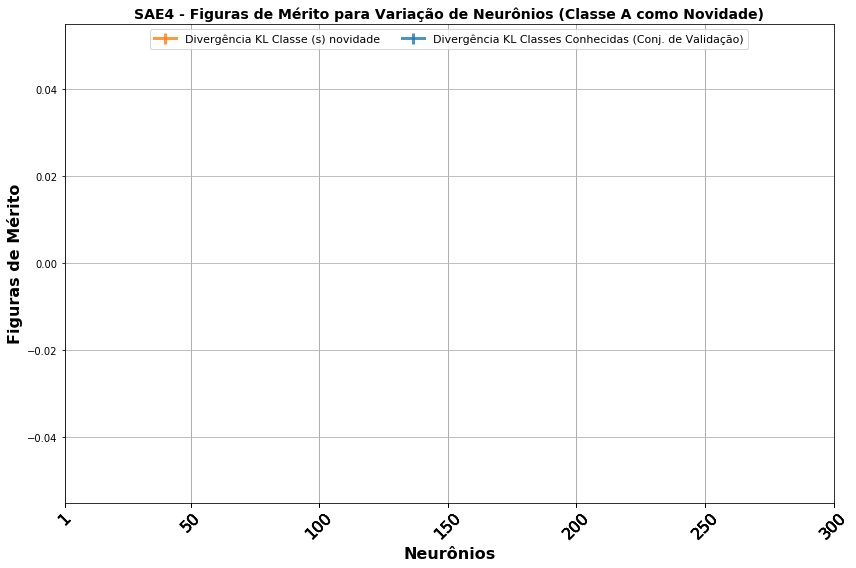

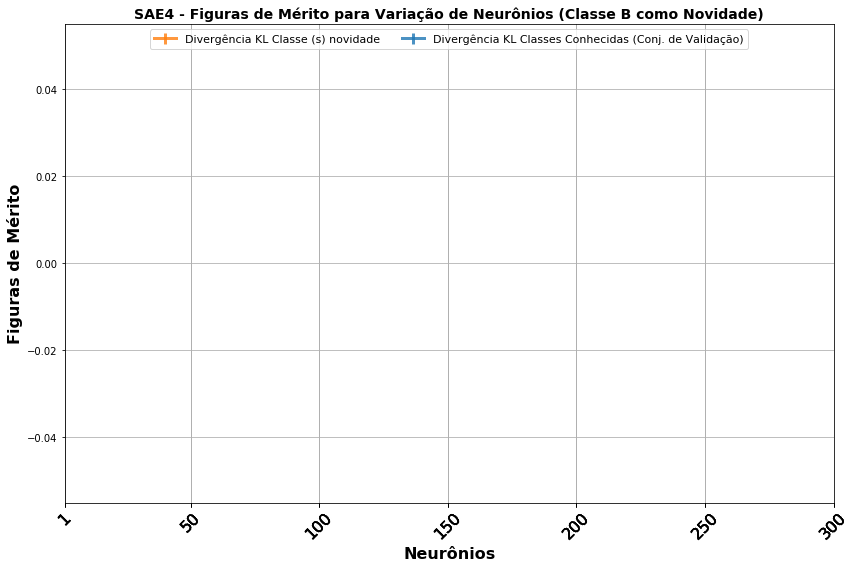

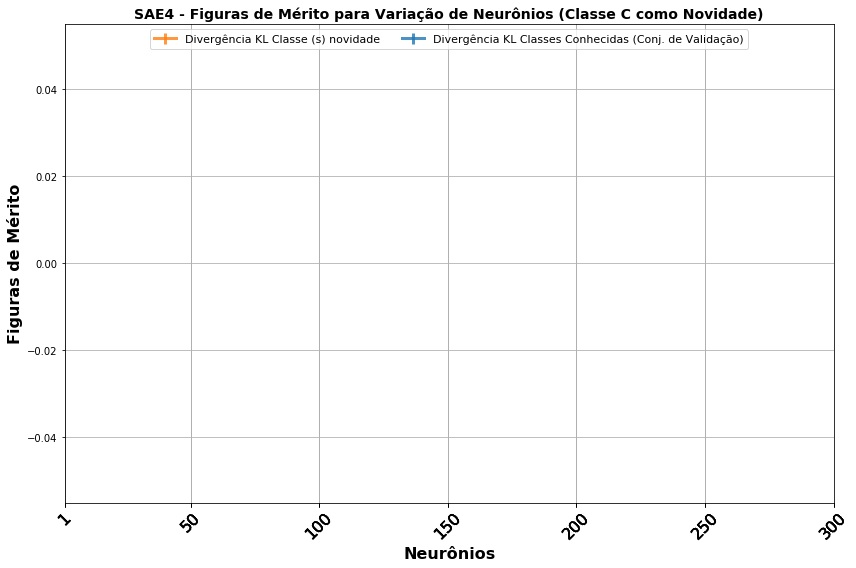

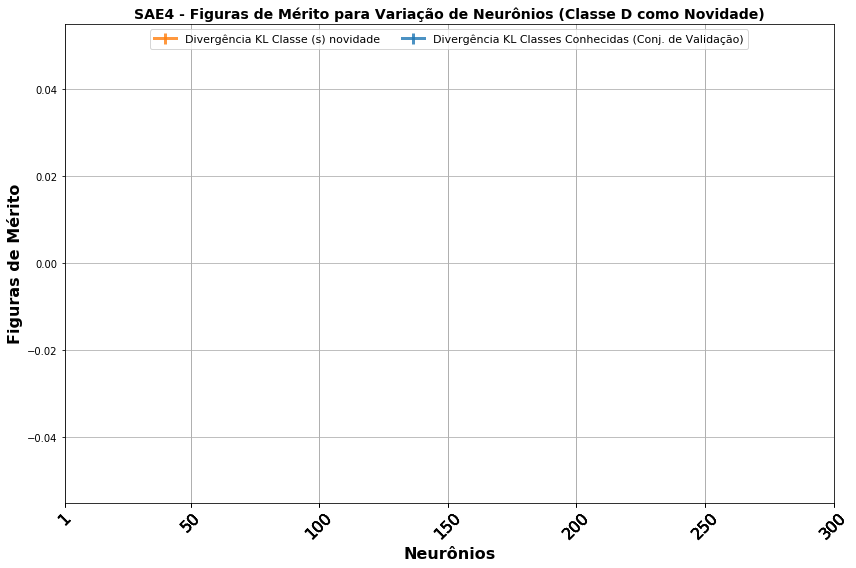

In [68]:
import pandas as pd
# analysis_name = "neurons_variation_results_dataframe"
# analysis_file = os.path.join(analysis.getBaseResultsPath(), "AnalysisFiles", analysis_name + ".csv")  
# results = pd.read_csv(analysis_file)

layer = 4
for inovelty in range(len(analysis.getClassLabels())):
    results_plot = results.query("novelty_class == '{0}' & layers == {1}".format(analysis.getClassLabels()[inovelty], layer))
    language = 'portuguese'
    labels_text = {
            'portuguese': {
                'neurons_value': 'Neurônios',
                'train_sp_index': 'Índice SP (Conj. de Treinamento)',
                'test_sp_index': 'Índice SP (Conj. de Validação)',
                'test_efficiency_A': 'Eficiência Classificação Classe A', 
                'test_efficiency_B': 'Eficiência Classificação Classe B', 
                'test_efficiency_C': 'Eficiência Classificação Classe C',
                'test_efficiency_D': 'Eficiência Classificação Classe D',
                'train_mse_known': 'MSE Classes Conhecidas (Conj. de Treinamento)',
                'test_mse_known': 'MSE Classes Conhecidas (Conj. de Validação)',
                'mse_novelty': 'MSE Classe(s) Novidade',
                'test_kl_div_known': 'Divergência KL Classes Conhecidas (Conj. de Validação)',
                'kl_div_novelty': 'Divergência KL Classe (s) novidade'
            },
            'english': {
                'neurons_value': 'Neurons',
                'train_sp_index': 'SP Index (Training Set)',
                'test_sp_index': 'SP Index (Test Set)',
                'test_efficiency_A': 'Efficiency Class A', 
                'test_efficiency_B': 'Efficiency Class B', 
                'test_efficiency_C': 'Efficiency Class C',
                'test_efficiency_D': 'Efficiency Class D',
                'test_mse_known': 'MSE Known Classes (Train Set)',
                'test_mse_known': 'MSE Known Classes (Test Set)',
                'mse_novelty': 'MSE Novelty Class',
                'test_kl_div_known': 'KL Divergence Known Classes (Test Set)',
                'kl_div_novelty': 'KL Divergence Novelty Class'
            }
    }

    #'test_mse_A', 'test_mse_B', 'test_mse_C', 'test_mse_D'
    columns_to_plot = [
                'fold',
                'neurons_value', 
#                 'train_f1_score',
#                 'test_f1_score',
#                 'train_accuracy',
#                 'test_accuracy',
#                 'train_recall',
#                 'test_recall',
#                 'train_precision',
#                 'test_precision',
#                 'test_mse_known',
#                 'mse_novelty',
#                 'train_sp_index',
#                 'test_sp_index', 
                'test_kl_div_known',
                'kl_div_novelty'
    ]
#                       'test_efficiency_A', 'test_efficiency_B', 'test_efficiency_C', 'test_efficiency_D']

    plot_title = {
        'portuguese': 'SAE{0} - Figuras de Mérito para Variação de Neurônios (Classe {1} como Novidade)',
        'english': 'SAE{0} - Figures-of-Merit for a Neurons Variation (Class {1} as Novelty)'
    }

    plot_axes_labels = {
        'portuguese': {
            'x': 'Neurônios',
            'y': u'Figuras de Mérito'
        },
        'english': {
            'x': 'Neurons',
            'y': 'Figures-of-Merit'
        }
    }

    results_plot = results_plot[columns_to_plot]
    
    data_mean = results_plot.groupby(['neurons_value']).mean()
    data_mean = data_mean.rename(columns=labels_text[language])
    
    if "fold" in data_mean.columns:
        data_mean.drop(columns=['fold'], inplace=True)
    
    data_std = results_plot.groupby(['neurons_value']).std()
    data_std = data_std.rename(columns=labels_text[language])
    
    ax = data_mean.plot(figsize=(12,8),
                   lw=3,
                   alpha=0.8,
                   style=['ko:','o-.','ko-'],
                   yerr=data_std
                   )
    ax.set_title(plot_title[language].format(layer, analysis.class_labels[inovelty]),
                     fontsize=14, fontweight='bold')
    ax.set_xlim([results_plot['neurons_value'].min(), results_plot['neurons_value'].max()])
    ax.set_xticks(results_plot['neurons_value'])
    ax.set_xticklabels(results_plot['neurons_value'],rotation=45, fontsize=16)


#     ax.set_ylim([0.0, 1.15])
#     y_ticks = np.arange(0.0,1.2,0.1)
#     ax.set_yticks(y_ticks)
#     y_tick_labels = 100*y_ticks[y_ticks<=1.0]
#     y_tick_labels = y_tick_labels.astype(int)
#     ax.set_yticklabels(y_tick_labels,fontsize=18)

    ax.grid()

    ax.set_xlabel(plot_axes_labels[language]['x'],fontsize=16,weight='bold')
    ax.set_ylabel(plot_axes_labels[language]['y'],fontsize=16,weight='bold')

    handles, labels = ax.get_legend_handles_labels()
    # sort both labels and handles by labels
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(handles, labels, ncol=3, loc='upper center', fontsize=11)

    plt.tight_layout()

    #Save the figure
    figure_name = "figures_of_merit_neurons_sweep_{}_layer".format(layer)
    file_name = os.path.join(analysis.pictures_output_folder, figure_name+"_novelty_class_{}.png".format(analysis.class_labels[inovelty]))
    plt.savefig(file_name, format="png")
    plt.show()
    try: 
        my_bot.sendMessage(message=plot_title[language].format(layer, analysis.class_labels[inovelty]), imgPath=file_name)
    except Exception as e:
        print("Error when sending the image to the bot. Error: {}".format(str(e)))